## 2. Training eines MLPs auf den Spielzeugdaten
Der Code aus dem Beispielnotebook muss zunächst an das Szenario aus der Vorlesung angepasst werden: ein deutlich kleineres Netzwerk mit eindimensionalem statt zehndimensionalem Output.

Das folgende Beispiel beruht auf einer angepassten Version des TensorFlow Beispiel welches unten abgebildet ist bzw. [hier](https://playground.tensorflow.org./#activation=sigmoid&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.65710&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) eigenständig durchgespielt werden kann. Die Netzwerkarchitektur, die Trainingsparameter und die Aktivierungsfunktion wurden wie in der folgenden Aufgabe angegeben festgelegt.

![TensorFlow Experiment 2](./data/experiment_2.png)

## 2.1 Hyperparameter und Netzarchitektur initialisieren
Setzen Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron
haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatritzen auf Korrektheit.

Zu beginn werden die Netzwerkparameter wie im Beispiel [training_eines_MLPLs_auf_MNIST](training_eines_MLPLs_auf_MNIST.ipynb) definiert.

In [169]:
# Netzwerkparameter laut Aufgabenbeschreibung

mbs = 10            # Größe des Mini-Batches
eta = 0.03          # Lernrate eta
epochs = 150        # Anzahl der Epochen
no_hidden = 2       # Anzahl der Neuronen pro versteckter Schicht

# Anzahl der Neuronen pro Schicht (2 Eingabe, 2 versteckte Schichten mit 2 Neuronen, 1 Ausgabe)
layers = [2, no_hidden, no_hidden, 1]

num_layers = len(layers)  # Anzahl der Schichten im Netzwerk
num_layers

4

Anschließend werden wie auch im Beispiel die Gewichte und Biases initialisiert und auf Korrektheit überprüft.

Sowohl die Biase als auch die Gewichte werden dabei mit **zufälligen Werten initialisiert**.

In [170]:
import numpy as np
biases = [np.random.randn(y, 1) for  y in layers[1:]]    # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]  # Gewichte

print("Shape of biases:")
for b in biases:
    print(b.shape)

print("\nShape of weights:")
for w in weights:
    print(f"{w.shape} (num weights: {w.size})")

Shape of biases:
(2, 1)
(2, 1)
(1, 1)

Shape of weights:
(2, 2) (num weights: 4)
(2, 2) (num weights: 4)
(1, 2) (num weights: 2)


**Erklärung Bias Shape:**
Da jedes Neuron nur einen Bias hat, ist die Anzahl der Biases in einer Schicht gleich der Anzahl der Neuronen in dieser Schicht. Somit ergibt sich für jede Schicht mit $k (k \geq 1)$ Neuronen ein Bias Array der Form $(L_k, 1)$ wobei $L_k$ die Anzahl der Neuronen in Schicht $k$ ist.

**Erklärung Gewicht Shape:**
Für die Gewichte zwischen Schicht $k-1$ und Schicht $k$ gilt: Gewichtsmatrix hat Form $(L_k, L_{k-1})$ (Zeilen = Neuronen der Zielschicht, Spalten = Neuronen der Quellschicht). Daher hat die letzte Gewichtsmatrix die Form (1, 2), da die Ausgabeschicht 1 Neuron und die vorherige Schicht 2 Neuronen hat.

$\rightarrow$ Die Eingangsschicht hat selbst weder Biases noch Gewichte, da sie nur die Eingabedaten weiterleitet.

Durch die oben erstellte Konfiguration ergibt sich ein Netzwerk mit folgender Architektur:
![Netzwerkarchitektur](./data/neural_network_exercise_full.drawio.png)

___

## 2.2 Inklurdieren von Hilfsfunktionen und anpassen der Evaluierungsfunktion
Der Beispielcode verwendet One-Hot-Coding für die Labels, in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion `evaluate()` im Code so abändern, dass ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Output kleiner als 0.5 ist und bei Klasse 1 größer als 0.5. 

Berechnen Sie zusätzlich den $MSE$ in dieser Funktion bei jedem Aufruf und speichern Sie diesen in einem zusätzlichen Array ab.

Für die folgenden Aufgabenteile wird auf teilweise modifizierten Code aus dem Beispielnotebook [training_eines_MLPLs_auf_MNIST](training_eines_MLPLs_auf_MNIST.ipynb) zurückgegriffen.

Im ersten Schritt muss die dort enthaltene Funktion `evaluate()` angepasst werden, um die Klassifikation entsprechend der neuen Anforderungen durchzuführen. Da diese jedoch von der Funktion welche den Vorwärtsdurchlauf durch das Netzwerk (`feedforward()`) abhängt muss zuerst diese sowie andere abhängige Funktionen inkludiert werden.

### Inkludieren der Aktivierungsfunktion

Zuerst werden die notwendigen Hilfsfunktionen (Aktivierungsfunktion) aus dem Beispielnotebook übernommen: `sigmoid()`, `sigmoid_prime(). Da diese lediglich elementare mathematische Operationen durchführen, müssen diese nicht angepasst werden.

Für diesen Aufgabenteil wird wie in der zweiten Vorlesung (02_backprop.pdf) auf S.22 die **Sigmoid-Aktivierungsfunktion** verwendet:
$$
\sigma(z^l) = \frac{1}{1 + e^{-z^{l}}}
$$
mit der Ableitung:
$$
\sigma'(z^l) = \sigma(z^l) \cdot (1 - \sigma(z^l))
$$

In [171]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

### Inkludieren der Kostenfunktion (*Loss Function*)
Zusätzlich soll der $MSE$ in dieser Funktion bei jedem Aufruf berechnet und in einem zusätzlichen Array abgespeichert werden. Der **Mean Squared Error (MSE)** wird wie in der Vorlesung wie folgt definiert:
$$
C(a^L) = \frac{1}{2} \sum_k (y_k - a^L_k)^2
$$
mit dem **Gradienten**:
$$
\nabla_{a^L}C = \frac{\partial C}{\partial a^L} = a^L - y
$$

In [172]:
# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives ∂C/∂a for the output activations."""
    return (output_activations-y)

In [173]:
# MSE-Kostenfunktion
def cost(output_activations, y):
    """
    Return the MSE cost.
    #### Arguments:
        output_activations -- The output activations from the network
        y -- The true labels
    #### Returns:
        The MSE cost as a float value
    """
    return (0.5 * np.linalg.norm(output_activations - y) ** 2)

#### &#9432; **Recap *Loss Fuction***

Die **Kostenfunktion** (engl. *cost function* oder *loss function*) ist eine mathematische Funktion, die misst, **wie gut oder schlecht** ein Modell derzeit arbeitet. Sie sagt also aus:

&#8594; *Wie weit sind die Vorhersagen des Modells von den tatsächlichen Werten entfernt?*

Ziel des Trainingsprozesses ist es, die Kostenfunktion zu minimieren, also die Vorhersagen des Modells so genau wie möglich zu machen. Dies geschieht durch Anpassung der Modellparameter (z.B. Gewichte und Biases in einem neuronalen Netzwerk) mittels Optimierungsalgorithmen wie dem Gradientenabstieg.

##### &#9432; Beispiel mit genutzter Kostenfunktion

In der hier betrachteten Aufgabe handelt es sich um ein binäres Klassifikationsproblem, bei dem die Mean Squared Error (**MSE**) als Kostenfunktion verwendet wird.

Als Aktivierungsfunktion wird die *Sigmoid-Funktion* genutzt dessen Ausgabe Werte zwischen 0 und 1 annehmen kann. Die "Vorhersage" des Modells $a^L$ kann somit Werte in diesem Bereich annehmen und als Wahrscheinlichkeit interpretiert werden, dass ein bestimmtes Eingabebeispiel zur Klasse 1 gehört.

Angenommen wir haben ein:
- Eingabebeispiel mit dem tatsächlichen Label $y = 1$ (also Klasse 1)
- Vorhersage des Modells $a^L = 0.0173$ mit $\sigma(-4)$ (also ca. 1.73% Wahrscheinlichkeit für Klasse 1 mit stark negativem $z$-Wert und Sigmoid nahe 0)

Ergibt sich mit der hier genutzten Kostenfunktion folgender *Loss* Wert:
$$
C(a^L) = \frac{1}{2} (y_k - a^L_k)^2 = \frac{1}{2} (1 - 0.0173)^2 = 0.4828
$$

##### &#9432; Warum ist MSE hier nicht sinnvoll?

Der *Loss* von 0.4828 zeigt an, dass die Vorhersage des Modells (1.73% Wahrscheinlichkeit für Klasse 1) von dem tatsächlichen Label (Klasse 1) abweicht jedoch ist der nummerische Loss mit 0.4828 relativ moderat obwohl die Vorhersage des Modells sehr stark vom wahren Wert abweicht. Das hierbei auftretende Problem soll noch mit dem kompletten Backpropagation-Algorithmus verdeutlicht werden:

Wir betrachten dabei die folgenden initialen Werte:
- $y = 1$ (tatsächliches Label/ Zielwert)
- $z^L = -4$ (stark negativer Wert vor Aktivierungsfunktion in der Ausgabeschicht)
- $\eta = 0.03$ (Lernrate)
- $w^L = [0.5, -0.5]$ (initiale Gewichte der Ausgabeschicht)

**1. Modell macht eine Vorhersage**:

Für den Vorwärtsdurchlauf durch das Netzwerk ergibt sich die Vorhersage:
$$
a^L = \sigma(z^L) = \sigma(-4) \approx 0.0173
$$
Das Modell schätzt also die Wahrscheinlichkeit für Klasse 1 auf ca. 1.73% obwohl das tatsächliche Label 1 ist.

**2. Kostenfunktion bewertet die Vorhersage (Loss Berechnung)**:

Für dieses Beispiel ergibt sich der Loss:
$$
C(a^L) = \frac{1}{2} (y - a^L)^2 = \frac{1}{2} (1 - 0.0173)^2 \approx 0.4828
$$

**3. Backpropagation berechnet den Gradienten (mit Kettenregel)**:

Der Gradient der Kostenfunktion bezüglich der Aktivierung in der Ausgabeschicht ist (siehe auch `cost_derivative()` Funktion):
$$
\nabla_{a^L}C = a^L - y = 0.0173 - 1 = -0.9827
$$

Der Gradient der Aktivierungsfunktion (Sigmoid) bezüglich des gewichteten Inputs $z^L$ ist:
$$
\sigma'(z^L) = \sigma(z^L) \cdot (1 - \sigma(z^L)) = 0.0173 \cdot (1 - 0.0173) \approx 0.0170
$$

Der Gradient der Kostenfunktion bezüglich des gewichteten Inputs $z^L$ ist somit (siehe hierzu auch `backprop()` Funktion ab Zeile 23):
$$
\nabla_{z^L}C = \nabla_{a^L}C \cdot \sigma'(z^L) = -0.9827 \cdot 0.0170 \approx -0.0167
$$

**4. Gewichte und Biases werden aktualisiert**:
Die Gewichte werden mit dem Gradientenabstiegsverfahren aktualisiert:
$$
w^L = w^L - \eta \cdot \nabla_{z^L}C \cdot a^{L-1} = [0.5, -0.5] - 0.03 \cdot (-0.0167) \cdot a^{L-1}
$$
Angenommen $a^{L-1} = [0.6, 0.4]$ (Aktivierungen der vorherigen Schicht), dann ergibt sich:
$$
w^L \approx [0.5, -0.5] + [0.0003, 0.0002] = [0.5003, -0.4998]
$$

> &#9888; **Problematische Erkenntnis:**
>
>Trotz der großen Abweichung der Vorhersage vom tatsächlichen Label (1.73% vs. 100%), ist der Gradient $\nabla_{z^L}C$ mit ca. -0.0167 relativ klein. Dies führt dazu, dass die Gewichte nur minimal angepasst werden (nur um ca. 0.0003 bzw. 0.0002). Dadurch lernt das Modell sehr langsam, insbesondere wenn die Vorhersagen stark von den tatsächlichen Labels abweichen. Um dies zu beheben wird in Aufgabe [1.4](exercise_1_4.ipynb) eine passendere Kostenfunktion (Verlustfunktion für logistische Regression, die *Kreuzentropie* bzw. *Cross-Entropy CE*) genutzt.

### Feedforward-Funktion

Anschließend wird die `feedforward()`-Funktion aus dem Beispielnotebook übernommen, welche den Vorwärtsdurchlauf durch das Netzwerk implementiert. Auch diese Funktion muss nicht angepasst werden, da sie lediglich die Aktivierungen der Neuronen berechnet.



In [174]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

### Evaluierungsfunktion anpassen

Nun kann die `evaluate()`-Funktion angepasst werden, um die Klassifikation entsprechend der neuen Anforderungen durchzuführen. Zusätzlich wird der $MSE$ berechnet und in einem Array abgespeichert.

Da es sich bei der Aktivierungsfunktion um eine Sigmoidfunktion handelt die nur Werte im Intervall $(0,1)$ annimmt, wird ein Schwellenwert von $0.5$ verwendet um die Klassenzugehörigkeit zu bestimmen. 

Ist die Vorhersage des Netzwerks für ein Beispiel größer oder gleich 0.5, so wird das Beispiel der Klasse 1 zugeordnet, andernfalls der Klasse 0. Ein Beispiel gilt als korrekt klassifiziert, wenn die vorhergesagte Klasse (`cpred`) mit dem tatsächlichen Label (`c` bzw. `y`) übereinstimmt (`c == ypred`S).

In [175]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    loss = []   # Liste zur Speicherung der Verluste (Erweiterung laut Aufgabenbeschreibung)
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        # Eingabe- und Ausgabedaten extrahieren
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Die Vorhersage ist 1, wenn die Ausgabe > 0.5 ist, sonst 0
        cpred = 1 if ypred >= 0.5 else 0

        # Das tatsächliche Label
        c = y
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1

        # Loss berechnen und speichern (Erweiterung laut Aufgabenbeschreibung)
        loss.append(cost(ypred, y))
        
    return correct, loss

___

## 2.3 Netz trainieren und Ergebnisse vergleichen
Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar. Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierung zuweilen in lokalen Minima hängenbleiben kann. Wiederholen Sie Ihren Versuch daher mehrere Male und vergeleichen Sie die Ergebnisse.

### Datensätze generieren

Wie in Aufgabe 1 [exercise_1_1](exercise_1_1.ipynb) gezeigt müssen zuerst die Daten auch für diese Aufgabe wieder entsprechend generiert werden. Hierzu werden wie auch in der vorherigen Aufgabe beschrieben zum erstellen der Labels und Design-Matrizen die Funktionen `get_labels()` und `build_design_matrix()` aus der Datei [`auxiliary.py`](auxiliary.py) verwendet.

In [176]:
import numpy as np

from auxiliary import get_labels, build_design_matrix

# Erstellen der Datenpunkte im vorgegebenen Bereich für Training und Test
X_train = np.random.uniform(-6, 6, (200, 2))
X_test = np.random.uniform(-6, 6, (200, 2))

# Labels für Trainings- und Testdaten generieren
y_train = get_labels(X_train)
y_test = get_labels(X_test)

# Gewichtungsvektoren für x- und y-Richtung
w_x = np.array([1, 0])
w_y = np.array([0, 1])

# Design Matrix für das Gitter erstellen
xv = np.linspace(-6, 6, 100)
yv = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(xv, yv)

design = np.c_[X.ravel(), Y.ravel()]

# Design-Matrizen für Trainings- und Testdaten erstellen sowie für das Gitter
design_X_train = build_design_matrix(X_train, w_x, w_y)
design_X_test = build_design_matrix(X_test, w_x, w_y)
design_grid = build_design_matrix(design, w_x, w_y)

### Backpropagation-Algorithmus

In [177]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

### Minibatch

In [178]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    #print("shape weights:")
    #for w in weights:
    #        print(f"{w.shape}")

    return (weights, biases)

### Stochastischer Gradientenabstieg

In [179]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    precision_curve =   []  # Liste zur Speicherung der Präzisionswerte (Erweiterung laut Aufgabenbeschreibung)
    mse_curve =         []  # Liste zur Speicherung der MSE-Werte (Erweiterung laut Aufgabenbeschreibung)

    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)

    print("| Epochs | Precision | Loss   |")
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j], loss = evaluate(x2, y2)

        precision_curve.append(acc_val[j] / n_test)  # Präzisionswert speichern
        mse_curve.append(np.mean(loss))              # MSE-Wert speichern

        if j % 10 == 0 or j == epochs - 1:
            print("|  {:>5} |   {:>6.4f}  | {:>6.4f} |".format(j+1, precision_curve[-1], mse_curve[-1]))
    
    return acc_val, precision_curve, mse_curve

### Training des Netzwerks

In [180]:
acc_val, precision, loss = SGD(design_X_train, y_train, epochs, mbs, eta, X_test, y_test)

| Epochs | Precision | Loss   |


|      1 |   0.5100  | 0.1333 |
|     11 |   0.5600  | 0.1263 |
|     21 |   0.5900  | 0.1245 |
|     31 |   0.5950  | 0.1240 |
|     41 |   0.5850  | 0.1238 |
|     51 |   0.5600  | 0.1235 |
|     61 |   0.5500  | 0.1233 |
|     71 |   0.5500  | 0.1232 |
|     81 |   0.5450  | 0.1230 |
|     91 |   0.5550  | 0.1229 |
|    101 |   0.5550  | 0.1228 |
|    111 |   0.5500  | 0.1227 |
|    121 |   0.5550  | 0.1226 |
|    131 |   0.5500  | 0.1225 |
|    141 |   0.5550  | 0.1224 |
|    150 |   0.5550  | 0.1223 |


### Darstellen der Lernkurven

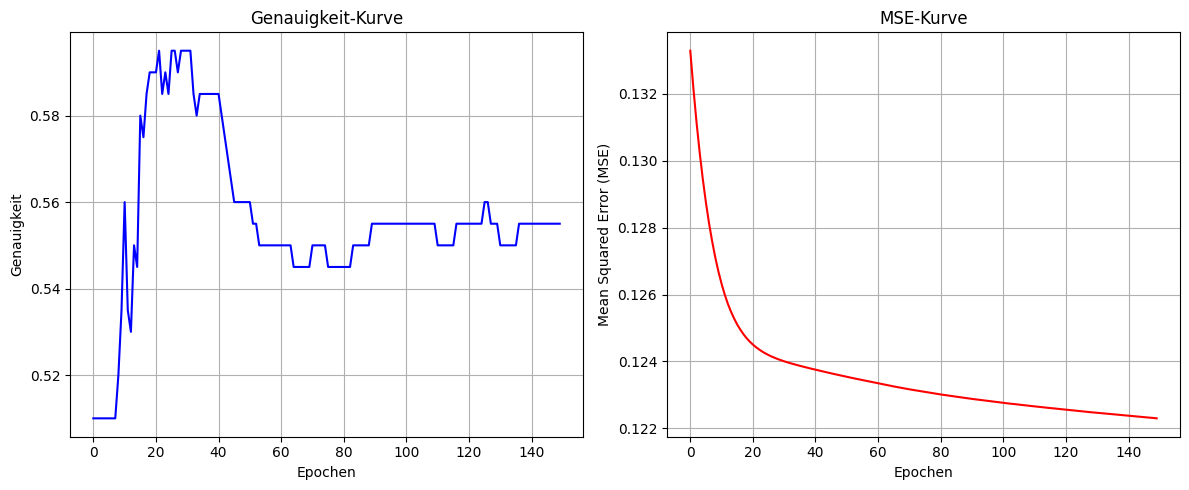

In [181]:
from matplotlib import pyplot as plt

### Darstellen der Lernkurven
# Genauigkeit-Kurve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), precision, label='Genauigkeit', color='blue')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit-Kurve')
plt.grid()
# MSE-Kurve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='MSE', color='red')
plt.xlabel('Epochen')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE-Kurve')
plt.grid()
plt.tight_layout()
plt.show()

Die MSE und Genauigkeit werden während des Trainings in Listen gespeichert und anschließend geplottet, um die Lernkurven darzustellen. Hierbei sind je nach Durchlauf aber nur geringe Verbesserungen zu erkennen, da das Netzwerk evtl. in lokalen Minima hängen bleibt.

___

## 2.4 Entscheidungsfunktion visualisieren
Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 × 100-Gitter und stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

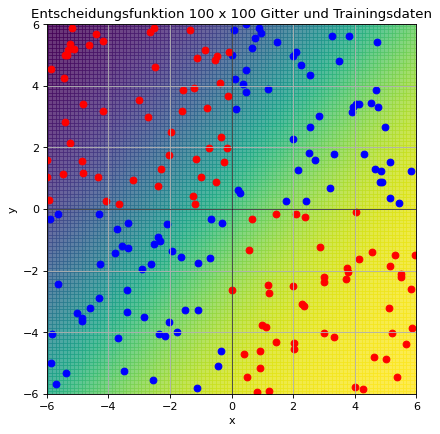

In [182]:
mlp_design_decision = feedforward(design_grid.T)

figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=80)
axis_limits = [-6, 6]

# Plot der Entscheidungsfunktion
axis.pcolor(X, Y, mlp_design_decision.reshape(100,100), alpha=.8)
axis.grid(True)
axis.set_title("Entscheidungsfunktion 100 x 100 Gitter und Trainingsdaten")
axis.set_xlabel("x")
axis.set_ylabel("y")
axis.axhline(0, color='black', linewidth=0.5)
axis.axvline(0, color='black', linewidth=0.5)
axis.set_xlim(axis_limits)
axis.set_ylim(axis_limits)
axis.set_aspect('equal')

# Scatter-Plot der Labels
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Label 1')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Label 0')

plt.show()